# ASDA - Assignment 09 (Model Simplification/Reduction) - Group 5

## 2) Agriculture Yield Dataset (2nd Version)

### Importing Libraries

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn import metrics
from statsmodels.formula.api import ols
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error, r2_score

### Importing dataset

In [10]:
df = pd.read_csv(r"E:\Leauphana\winter2425\ASDA\splityield.txt", sep="\\t", engine="python").rename(columns={"yield":"yield_output"})
df.head()

,yield_output,block,irrigation,density,fertilizer
0,90,A,control,low,N
1,95,A,control,low,P
2,107,A,control,low,NP
3,92,A,control,medium,N
4,89,A,control,medium,P


### EDA

In [11]:
print("info: \n", df.info(),"\n")
print("Descriptive Stat: \n", df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   yield_output  72 non-null     int64 
 1   block         72 non-null     object
 2   irrigation    72 non-null     object
 3   density       72 non-null     object
 4   fertilizer    72 non-null     object
dtypes: int64(1), object(4)
memory usage: 2.9+ KB
info: 
 None 

Descriptive Stat: 
        yield_output
count     72.000000
mean      99.722222
std       18.292015
min       60.000000
25%       86.000000
50%       95.000000
75%      114.000000
max      136.000000


### Helper Functions:

In [12]:
def check_dist_by_grp(x):
    sns.boxplot(x=x, y="yield_output", data=df)
    plt.title(f"Yield by: {x}")
    plt.show()
    

# Step 1: Importing the data and checking for missing values
def load_data(file_path):
    data = pd.read_csv(file_path)
    print("Missing values in dataset:\n", data.isnull().sum())
    return data

# Step 2: Inspecting the distributions of the data
def inspect_distributions(X, y):
    # Combine X and y for pairplot
    data = X.copy()
    data['yield_output'] = y
    sns.pairplot(data)
    plt.show()
    print("Summary statistics of the dataset:\n", data.describe())

# Step 3: Checking for correlations among predictors
def check_correlations(X):
    corr_matrix = X.corr()
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
    plt.show()

# Step 4: Variance Inflation Factor (VIF) to detect multicollinearity
def check_vif(X):
    # Ensure that there are no missing values before calculating VIF
    X = X.dropna()
    
    # Calculate VIF for each variable
    vif_data = pd.DataFrame()
    vif_data["Variable"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    
    print("Variance Inflation Factors:\n", vif_data)
    return vif_data

# Step 5: Preprocessing the data - One-hot encoding the categorical predictors
def preprocess_data(X):
    # One-hot encode categorical columns
    X_encoded = pd.get_dummies(X, drop_first=True)
    return X_encoded

# Step 6: Scaling the predictors (after encoding)
def scale_predictors(X_encoded):
    scaler = MinMaxScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X_encoded), columns=X_encoded.columns)
    return X_scaled

# Build the full GLM model
def build_full_model(X, y):
    formula = 'yield_output ~ ' + ' + '.join(X.columns)
    model = smf.glm(formula=formula, data=pd.concat([X, y], axis=1), family=sm.families.Poisson()).fit()
    print(model.summary())
    return model

# Step 8: Backward elimination of non-significant variables
def backward_elimination(X, y):
    # Start with all predictors
    predictors = X.columns.tolist()
    formula = 'yield_output ~ ' + ' + '.join(predictors)
    
    while True:
        # Build the model using the current formula
        model = smf.glm(formula=formula, data=pd.concat([X, y], axis=1), family=sm.families.Poisson()).fit()
        
        # Get the maximum p-value from the current model
        max_p_value = model.pvalues.max()
        
        if max_p_value > 0.05:  # If the highest p-value is greater than 0.05, remove the variable
            excluded_variable = model.pvalues.idxmax()
            print(f"Removing {excluded_variable} with p-value {max_p_value}")
            
            # Remove the excluded variable from the list of predictors
            predictors.remove(excluded_variable)
            
            # Rebuild the formula without the excluded variable
            formula = 'yield_output ~ ' + ' + '.join(predictors)
        else:
            break
    
    print("Final model variables:", predictors)
    final_model = smf.glm(formula=formula, data=pd.concat([X, y], axis=1), family=sm.families.Poisson()).fit()
    print(final_model.summary())
    
    return final_model


# Step 9: Compare minimum adequate model with null model
def compare_models_with_null(model, X, y):
    null_formula = 'yield_output ~ 1'  # Null model with no predictors
    null_model = smf.glm(formula=null_formula, data=pd.concat([X, y], axis=1), family=sm.families.Poisson()).fit()
    print("Null model AIC:", null_model.aic)
    print("Full model AIC:", model.aic)

# Step 10: Reduction using AIC to build candidate models
def build_candidate_models(X, y):
    candidate_models = []
    formula = 'yield_output ~ ' + ' + '.join(X.columns)
    model1 = smf.glm(formula=formula, data=pd.concat([X, y], axis=1), family=sm.families.Poisson()).fit()
    candidate_models.append(model1)
    
    for var in X.columns:
        reduced_formula = formula.replace(' + ' + var, '')
        model = smf.glm(formula=reduced_formula, data=pd.concat([X, y], axis=1), family=sm.families.Poisson()).fit()
        candidate_models.append(model)
        
    return candidate_models

# Step 11: Comparing candidate models with AIC
def compare_candidate_models(candidate_models):
    best_model = min(candidate_models, key=lambda model: model.aic)
    print("Best Model AIC:", best_model.aic)
    return best_model

# Step 12: Splitting the dataset and calculating AUC
def split_and_calculate_auc(X, y, test_size=0.3):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    
    # Fit the model
    formula = 'yield_output ~ ' + ' + '.join(X.columns)
    model = smf.glm(formula=formula, data=pd.concat([X_train, y_train], axis=1), family=sm.families.Poisson()).fit()
    
    # Predict the target for the test set
    y_pred = model.predict(X_test)
    
    # For regression tasks, use R-squared or Mean Squared Error (MSE)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"Test size: {test_size}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"R-squared: {r2}")

# Step 13: Experimenting with different train-test splits
def experiment_with_splits(X, y):
    split_ratios = [0.1, 0.3, 0.5]
    for ratio in split_ratios:
        split_and_calculate_auc(X, y, test_size=ratio)


### Distribution

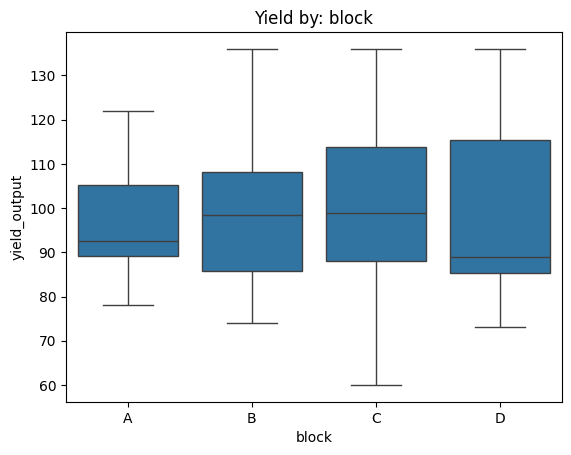

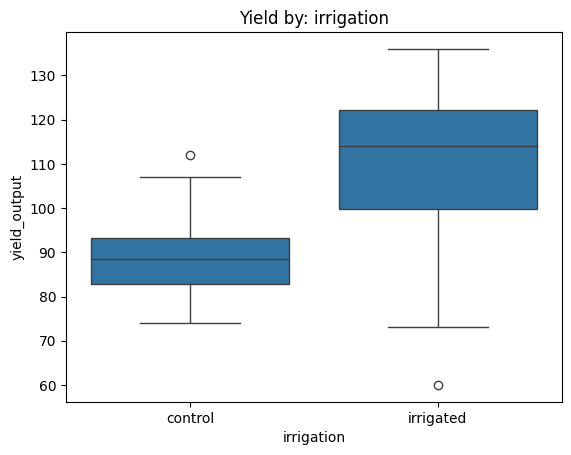

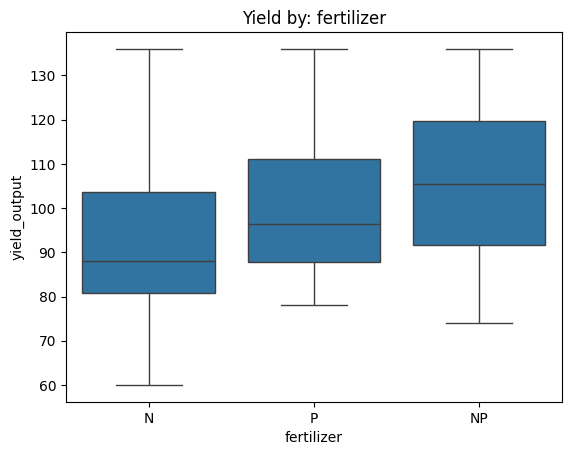

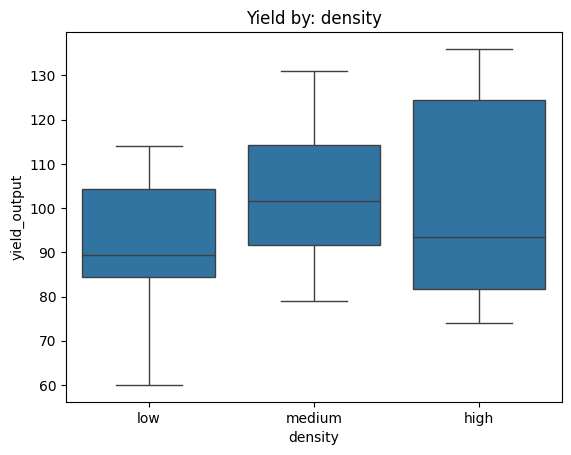

In [13]:
dist_plot_list = ["block", "irrigation", "fertilizer", "density"]

for i in dist_plot_list:
    check_dist_by_grp(i)

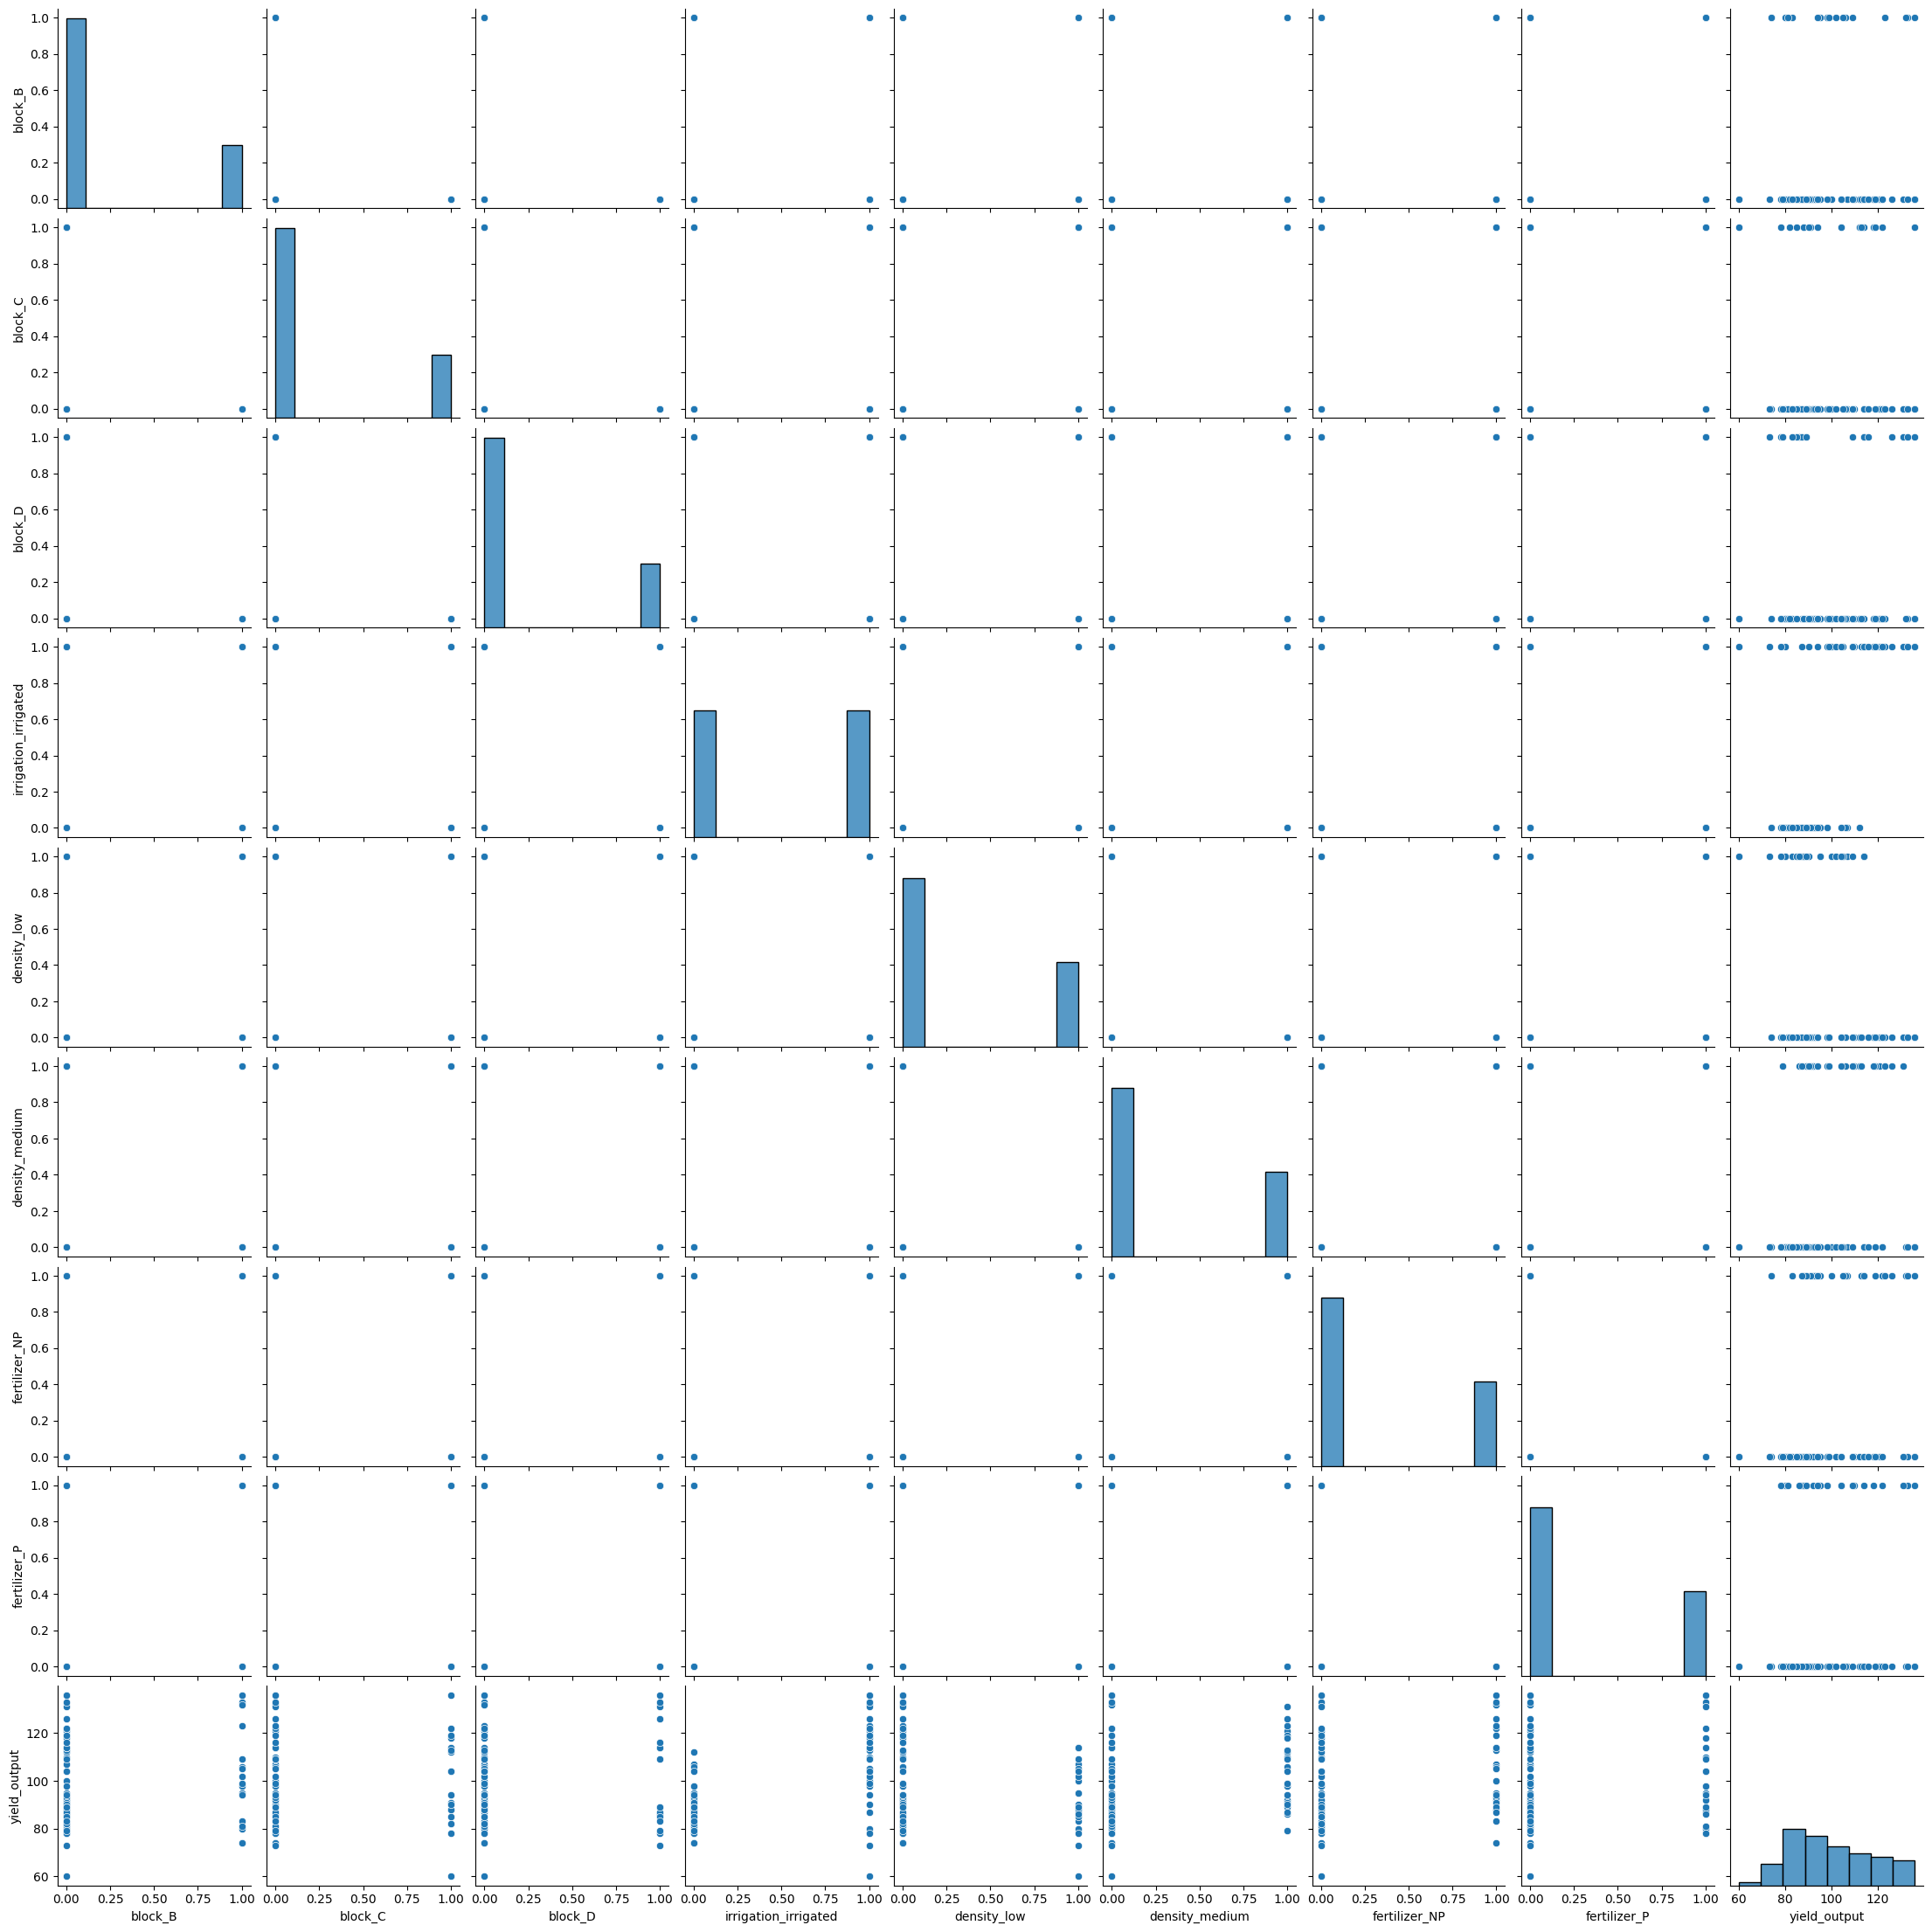

Summary statistics of the dataset:
          block_B    block_C    block_D  irrigation_irrigated  density_low  \
count  72.000000  72.000000  72.000000             72.000000    72.000000   
mean    0.250000   0.250000   0.250000              0.500000     0.333333   
std     0.436051   0.436051   0.436051              0.503509     0.474713   
min     0.000000   0.000000   0.000000              0.000000     0.000000   
25%     0.000000   0.000000   0.000000              0.000000     0.000000   
50%     0.000000   0.000000   0.000000              0.500000     0.000000   
75%     0.250000   0.250000   0.250000              1.000000     1.000000   
max     1.000000   1.000000   1.000000              1.000000     1.000000   

       density_medium  fertilizer_NP  fertilizer_P  yield_output  
count       72.000000      72.000000     72.000000     72.000000  
mean         0.333333       0.333333      0.333333     99.722222  
std          0.474713       0.474713      0.474713     18.292015  
mi

In [14]:
data = df.copy()

# Separate predictors and target variable
X = data.drop(columns=['yield_output'])
y = data['yield_output']

# Preprocess and encode categorical data
X_encoded = preprocess_data(X)

# Scale the encoded predictors
X_scaled = scale_predictors(X_encoded)

# Inspect data
inspect_distributions(X_scaled, y)

# check_correlations(X_scaled)

vif_data = check_vif(X_scaled)
redundant_cols = vif_data[vif_data["VIF"] > 10]["Variable"]
X_scaled = X_scaled.drop(columns=redundant_cols)

# Build the full GLM model
full_model = build_full_model(X_scaled, y)

# Perform backward elimination
reduced_model = backward_elimination(X_scaled, y)

# Compare with null model
compare_models_with_null(reduced_model, X_scaled, y)

# Build candidate models and select the best model based on AIC
candidate_models = build_candidate_models(X_scaled, y)
best_model = compare_candidate_models(candidate_models)

# Experiment with different train-test splits
experiment_with_splits(X_scaled, y)


### ANOVA

In [15]:
# Fit the ANOVA model
model = ols("yield_output ~ C(block) + C(irrigation) + C(density) + C(fertilizer)", data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)


                     sum_sq    df          F        PR(>F)
C(block)         194.444444   3.0   0.353577  7.866939e-01
C(irrigation)   8277.555556   1.0  45.155624  6.137816e-09
C(density)      1758.361111   2.0   4.796095  1.151318e-02
C(fertilizer)   1977.444444   2.0   5.393666  6.883359e-03
Residual       11548.638889  63.0        NaN           NaN


In [16]:
anova_model_refined = ols("yield_output ~ C(irrigation) + C(fertilizer) + C(density)", data=df).fit()
anova_table_refined = sm.stats.anova_lm(anova_model_refined, typ=2)
print(anova_table_refined)


                     sum_sq    df          F        PR(>F)
C(irrigation)   8277.555556   1.0  46.522591  3.370597e-09
C(fertilizer)   1977.444444   2.0   5.556945  5.882660e-03
C(density)      1758.361111   2.0   4.941285  1.000606e-02
Residual       11743.083333  66.0        NaN           NaN


In [17]:
model_used, model_aic, model_deviance = [], [], []

### Null Model

In [18]:
# null model
formula = "yield_output ~ 1"
model = smf.glm(formula, df, family = sm.families.Gaussian()) # https://www.statsmodels.org/stable/glm.html#families
result = model.fit()
print(result.summary())
model_used.append('null model')
model_aic.append(result.aic)
model_deviance.append(result.deviance)
print("The result of the AIC is: ")
print(round(result.aic))

                 Generalized Linear Model Regression Results                  
Dep. Variable:           yield_output   No. Observations:                   72
Model:                            GLM   Df Residuals:                       71
Model Family:                Gaussian   Df Model:                            0
Link Function:               Identity   Scale:                          334.60
Method:                          IRLS   Log-Likelihood:                -310.93
Date:                Mon, 16 Dec 2024   Deviance:                       23756.
Time:                        23:29:37   Pearson chi2:                 2.38e+04
No. Iterations:                     3   Pseudo R-squ. (CS):          9.735e-05
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     99.7222      2.156     46.259      0.0

### Full Model

In [19]:
# full model
formula = "yield_output ~ C(irrigation) * C(fertilizer) * C(density)"
model = smf.glm(formula, df, family = sm.families.Gaussian()) # https://www.statsmodels.org/stable/glm.html#families
result = model.fit()
print(result.summary())
model_used.append('full model')
model_aic.append(result.aic)
model_deviance.append(result.deviance)
print("The result of the AIC is: ")
print(round(result.aic))

                 Generalized Linear Model Regression Results                  
Dep. Variable:           yield_output   No. Observations:                   72
Model:                            GLM   Df Residuals:                       54
Model Family:                Gaussian   Df Model:                           17
Link Function:               Identity   Scale:                          138.94
Method:                          IRLS   Log-Likelihood:                -269.43
Date:                Mon, 16 Dec 2024   Deviance:                       7503.0
Time:                        23:29:37   Pearson chi2:                 7.50e+03
No. Iterations:                     3   Pseudo R-squ. (CS):             0.8103
Covariance Type:            nonrobust                                         
                                                                          coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------

In [20]:
#candidate model

# Filter out the 'medium' category from the 'density' variable
df_filtered = df[df['density'] != 'medium']

# Define the formula for GLM
formula = "yield_output ~ C(irrigation) + C(fertilizer) + C(density)"

# Fit the GLM model with the filtered data
model = smf.glm(formula, data=df_filtered, family=sm.families.Gaussian())
result = model.fit()

# Print the summary of the model
print(result.summary())

# Store the model details
model_used.append('Refined model (without medium density)')
model_aic.append(result.aic)
model_deviance.append(result.deviance)

# Print the AIC for the refined model
print("The result of the AIC for the refined model is: ")
print(round(result.aic))

                 Generalized Linear Model Regression Results                  
Dep. Variable:           yield_output   No. Observations:                   48
Model:                            GLM   Df Residuals:                       43
Model Family:                Gaussian   Df Model:                            4
Link Function:               Identity   Scale:                          205.81
Method:                          IRLS   Log-Likelihood:                -193.32
Date:                Mon, 16 Dec 2024   Deviance:                       8849.6
Time:                        23:29:38   Pearson chi2:                 8.85e+03
No. Iterations:                     3   Pseudo R-squ. (CS):             0.6221
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [21]:
metrics = {"model used": model_used,
           "aic": model_aic,
           "deviance": model_deviance}

metrics_df = pd.DataFrame(metrics)
metrics_df

,model used,aic,deviance
0,null model,623.851045,23756.444444
1,full model,574.867380,7503.000000
2,Refined model (without medium density),396.630821,8849.645833
